In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [2]:
# Image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_path = 'C:/Users/AJ/OneDrive/Desktop/school/Nueral/Neural Jupyter/Project 2/dataset_2_split/dataset_2_split/train'
val_path = 'C:/Users/AJ/OneDrive/Desktop/school/Nueral/Neural Jupyter/Project 2/dataset_2_split/dataset_2_split/validation'
test_path = 'C:/Users/AJ/OneDrive/Desktop/school/Nueral/Neural Jupyter/Project 2/dataset_2_split/dataset_2_split/test'

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_directory(train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
val_data = val_test_datagen.flow_from_directory(val_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')
test_data = val_test_datagen.flow_from_directory(test_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

Found 6407 images belonging to 12 classes.
Found 1368 images belonging to 12 classes.
Found 1369 images belonging to 12 classes.


In [5]:
def build_resnet50_model(input_shape=(128, 128, 3), num_classes=12):
    # Load the ResNet50 base model with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers
    
    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Increase dropout
    
    x = Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)  # Increase dropout to 60%
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    # Define the model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.00003),  # Reduce learning rate
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the ResNet50 model
resnet50_model = build_resnet50_model()

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history_resnet50 = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, reduce_lr]  # Add callbacks
)

Epoch 1/50
201/201 [==============================] - 83s 400ms/step - loss: 3.9054 - accuracy: 0.0852 - val_loss: 2.5543 - val_accuracy: 0.0833 - lr: 3.0000e-05
Epoch 2/50
201/201 [==============================] - 77s 381ms/step - loss: 3.7080 - accuracy: 0.0943 - val_loss: 2.6201 - val_accuracy: 0.0826 - lr: 3.0000e-05
Epoch 3/50
201/201 [==============================] - 92s 458ms/step - loss: 3.6031 - accuracy: 0.1091 - val_loss: 2.6350 - val_accuracy: 0.1184 - lr: 3.0000e-05
Epoch 4/50
201/201 [==============================] - 84s 416ms/step - loss: 3.5646 - accuracy: 0.1119 - val_loss: 2.6367 - val_accuracy: 0.1206 - lr: 3.0000e-05
Epoch 5/50
201/201 [==============================] - 77s 384ms/step - loss: 3.4873 - accuracy: 0.1191 - val_loss: 2.6534 - val_accuracy: 0.1206 - lr: 3.0000e-05
Epoch 6/50
201/201 [==============================] - 92s 454ms/step - loss: 3.4568 - accuracy: 0.1174 - val_loss: 2.7254 - val_accuracy: 0.1272 - lr: 3.0000e-05
Epoch 7/50
201/201 [========

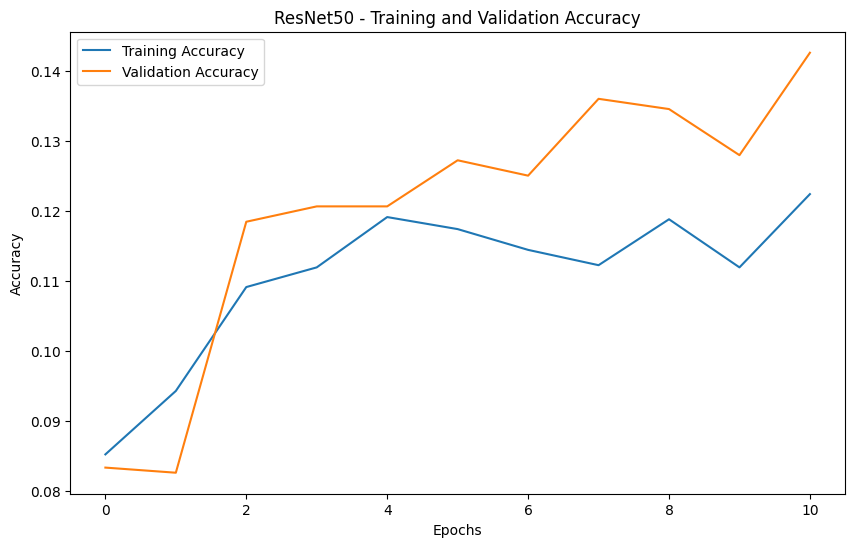

In [7]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ResNet50 - Training and Validation Accuracy')
plt.show()

In [8]:
# Evaluate on Test Data
test_loss, test_accuracy = resnet50_model.evaluate(test_data)
print(f'ResNet50 Test Accuracy: {test_accuracy * 100:.2f}%')

43/43 [==============================] - 27s 625ms/step - loss: 2.5511 - accuracy: 0.0833
ResNet50 Test Accuracy: 8.33%


43/43 [==============================] - 17s 355ms/step


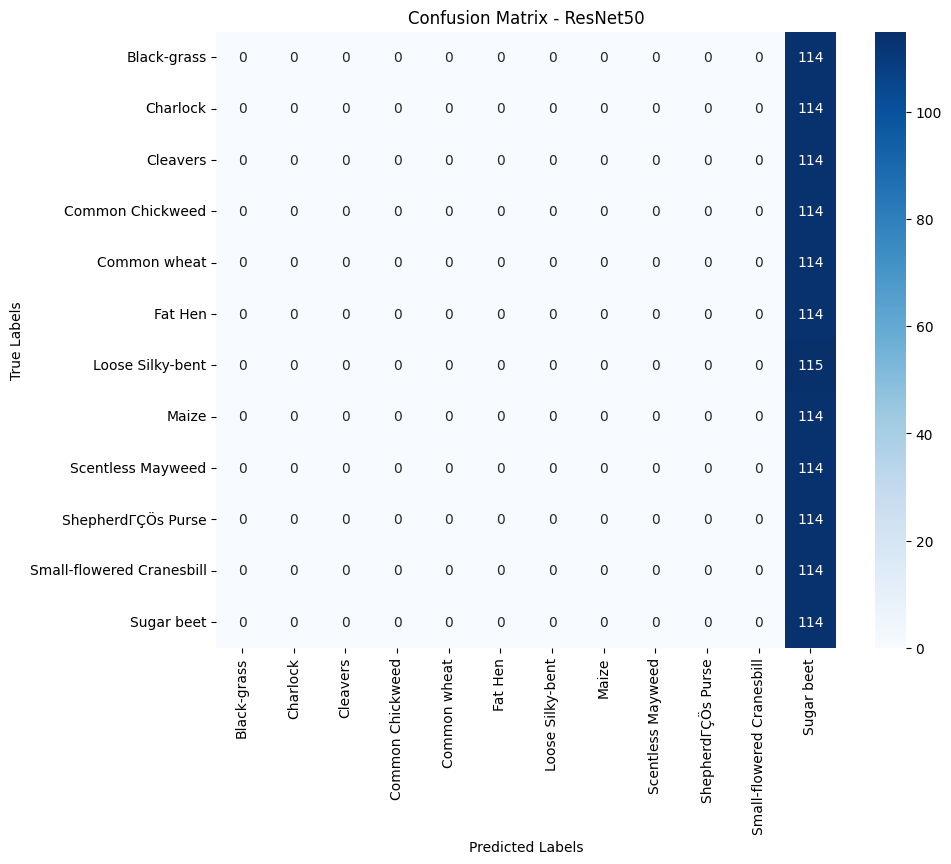

In [9]:
# Confusion Matrix and Classification Report
predictions = np.argmax(resnet50_model.predict(test_data), axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(true_classes, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - ResNet50')
plt.show()

In [10]:
print("Classification Report for ResNet50")
print(classification_report(true_classes, predictions, target_names=class_labels))

Classification Report for ResNet50
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00       114
                 Charlock       0.00      0.00      0.00       114
                 Cleavers       0.00      0.00      0.00       114
         Common Chickweed       0.00      0.00      0.00       114
             Common wheat       0.00      0.00      0.00       114
                  Fat Hen       0.00      0.00      0.00       114
         Loose Silky-bent       0.00      0.00      0.00       115
                    Maize       0.00      0.00      0.00       114
        Scentless Mayweed       0.00      0.00      0.00       114
       ShepherdΓÇÖs Purse       0.00      0.00      0.00       114
Small-flowered Cranesbill       0.00      0.00      0.00       114
               Sugar beet       0.08      1.00      0.15       114

                 accuracy                           0.08      1369
                macro avg

c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AJ\anaconda3\envs\Nueral-test\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [11]:
resnet50_model.save("resnet50_model_1.h5")
print("ResNet50 model saved as 'resnet50_model.h5'")

ResNet50 model saved as 'resnet50_model.h5'
